In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import re
import requests
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import nltk
# nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ejfel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ejfel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from sklearn.cluster import KMeans

In [5]:
with open('coffee_words.pickle','rb') as read_file:
    coffee = pickle.load(read_file)
with open('coffee_ratings.pickle','rb') as read_file:
    ratings = pickle.load(read_file)
with open('combined.pickle','rb') as read_file:
    combined = pickle.load(read_file)
with open('df_full.pickle','rb') as read_file:
    df = pickle.load(read_file)
with open('df_topic_breakdown.pickle','rb') as read_file:
    df_topic_breakdown = pickle.load(read_file)
with open('sentiment.pickle','rb') as read_file:
    sentiment = pickle.load(read_file)

with open('blindtfidf_vec.pickle', 'rb') as read_file:
    blindtfidf = pickle.load(read_file)
with open('blindtfidf_mat.pickle', 'rb') as read_file:
    tfidf_blind = pickle.load(read_file)

In [9]:
documents = df.Text
  
# raw documents to tf-idf matrix: 
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)
# SVD to reduce dimensionality: 
svd_model = TruncatedSVD(n_components=100,         #// num dimensions
                         algorithm='randomized',
                         n_iter=10)
# pipeline of tf-idf + SVD, fit to and applied to documents:
svd_transformer = Pipeline([('tfidf', vectorizer), 
                            ('svd', svd_model)])
svd_matrix = svd_transformer.fit_transform(documents)
# svd_matrix can later be used to compare documents, compare words, or compare queries with documents

In [19]:
from gensim.corpora import Dictionary
# from gensim.corpora.Dictionary import load_from_text, doc2bow
from gensim.corpora import MmCorpus
from gensim.models.ldamodel import LdaModel
document = df.Text
# load id->word mapping (the dictionary)
id2word = Dictionary.load_from_text('wiki_en_wordids.txt')
# load corpus iterator
mm = MmCorpus('wiki_en_tfidf.mm')
# extract 100 LDA topics, updating once every 10,000
lda = LdaModel(corpus=mm, id2word=id2word, num_topics=100, update_every=1, chunksize=10000, passes=1)
# use LDA model: transform new doc to bag-of-words, then apply lda
doc_bow = Dictionary.doc2bow(document.split())
doc_lda = lda[doc_bow]
# doc_lda is vector of length num_topics representing weighted presence of each topic in the doc

FileNotFoundError: [Errno 2] No such file or directory: 'wiki_en_wordids.txt'

## LDA from new site

In [20]:
vectorizer = CountVectorizer(min_df=10, stop_words = 'english',max_df=3200)
doc_word = vectorizer.fit_transform(df.Text.str.replace(r'\d+','',regex=True))

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
# vectorize the corpus
count_vectorizer = CountVectorizer(min_df=10, max_df=3200, ngram_range=(1,1), stop_words='english')
tfidf_vectorizer = TfidfVectorizer(min_df=10, max_df=3200, ngram_range=(1,1), stop_words='english')

# calculate the feature matrix
feature_matrix = count_vectorizer.fit_transform(df.Text.str.replace(r'\d+','',regex=True))
tfidf_feature_matrix = tfidf_vectorizer.fit_transform(df.Text.str.replace(r'\d+','',regex=True))


In [24]:
from sklearn.decomposition import LatentDirichletAllocation

# Instantiate the LDA model
lda_model = LatentDirichletAllocation(n_components=2, max_iter=100, learning_method='online', random_state=43,
                                     batch_size=128, evaluate_every=-1, n_jobs=-1)

# fit transform the feature matrix
lda_output = lda_model.fit_transform(feature_matrix)

# display the lda_output and its shape
display(lda_output)
display(lda_output.shape)

array([[0.82106008, 0.17893992],
       [0.83884816, 0.16115184],
       [0.9878912 , 0.0121088 ],
       ...,
       [0.0141855 , 0.9858145 ],
       [0.01430916, 0.98569084],
       [0.01325895, 0.98674105]])

(5959, 2)

In [25]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [2, 3, 4, 5, 10, 15, 20, 25], 'learning_decay': [.5, .7, .9]}

# Init the model
lda = LatentDirichletAllocation()

# Init Grid Search class
model = GridSearchCV(lda, search_params)

model.fit(feature_matrix)
best_lda_model = model.best_estimator_
print("Best model's params: ", model.best_params_)
print("Best log likelihood score: ", model.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(feature_matrix))

Best model's params:  {'learning_decay': 0.9, 'n_components': 2}
Best log likelihood score:  -530258.8187284933
Model perplexity:  937.0343214532029


In [26]:
df_cv_results = pd.DataFrame(model.cv_results_)
df_cv_results.to_csv("LDAGridSearchResults.csv", header=True, index=False, encoding='utf-8')

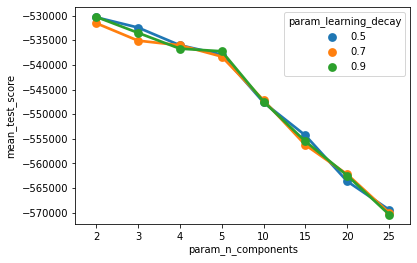

In [27]:
sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results)


In [41]:
best_lda_model
other_lda_model = LatentDirichletAllocation(learning_decay=0.9, n_components=5)

In [43]:
# Create a document to topic matrix
lda_output = other_lda_model.fit_transform(feature_matrix)

# lda_output = best_lda_model.transform(feature_matrix)
# column names
topicnames = ['Topic_' + str(i) for i in range(other_lda_model.n_components)]

# index names
docnames = ['Doc_' + str(i) for i in range(len(df.Text.str.replace(r'\d+','',regex=True)))]

# create a dataframe
df_document_topic = pd.DataFrame(np.round(lda_output,2), columns=topicnames, index=docnames)

df_document_topic.head(10)

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
Doc_0,0.00,0.0,0.61,0.00,0.37
Doc_1,0.00,0.0,0.56,0.00,0.43
Doc_2,0.00,0.0,0.00,0.00,0.99
Doc_3,0.00,0.0,0.00,0.00,0.99
Doc_4,0.00,0.0,0.08,0.07,0.85
Doc_5,0.00,0.0,0.12,0.00,0.87
Doc_6,0.00,0.0,0.29,0.18,0.52
Doc_7,0.06,0.0,0.00,0.00,0.93
Doc_8,0.00,0.0,0.00,0.42,0.57
Doc_9,0.00,0.0,0.00,0.00,0.98


In [44]:
df_document_topic.values

array([[0.  , 0.  , 0.61, 0.  , 0.37],
       [0.  , 0.  , 0.56, 0.  , 0.43],
       [0.  , 0.  , 0.  , 0.  , 0.99],
       ...,
       [0.98, 0.  , 0.  , 0.  , 0.  ],
       [0.98, 0.01, 0.01, 0.01, 0.01],
       [0.98, 0.01, 0.  , 0.  , 0.  ]])

In [45]:
# dominant topic
df_document_topic['dominant_topic'] = np.argmax(df_document_topic.values, axis=1)
df_document_topic.sample(20)

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,dominant_topic
Doc_1996,0.00,0.00,0.00,0.36,0.63,4
Doc_4038,0.29,0.00,0.00,0.70,0.00,3
Doc_4937,0.27,0.00,0.00,0.72,0.00,3
Doc_341,0.13,0.00,0.43,0.04,0.40,2
Doc_1046,0.00,0.00,0.85,0.00,0.14,2
Doc_3812,0.15,0.00,0.00,0.00,0.84,4
Doc_4797,0.98,0.01,0.01,0.01,0.00,0
Doc_4570,0.96,0.03,0.00,0.00,0.00,0
Doc_1593,0.00,0.00,0.00,0.00,0.99,4
Doc_2749,0.00,0.00,0.28,0.71,0.00,3


C:\Users\ejfel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


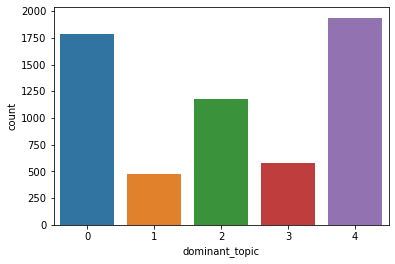

In [46]:
sns.countplot(df_document_topic.dominant_topic)

In [3]:
combined.head()

,roaster,origin,roast_level,group,rating,aroma,body,flavor,aftertaste,acidity
0,Jackrabbit Java,Costa Rica,Medium-Light,1,93,9.0,9.0,9.0,8.0,8.0
1,Jackrabbit Java,"Nyamasheke District, Rwanda",Medium-Light,0,92,9.0,8.0,9.0,8.0,8.0
2,Red Rooster Coffee Roaster,"Los Naranjos, La Argentina, Huila Department, ...",Light,0,96,9.0,9.0,10.0,9.0,9.0
3,Paradise Roasters,"Huila, Colombia",Light,0,95,9.0,9.0,9.0,9.0,9.0
4,Kakalove Cafe,"Antioquia Department, Colombia",Medium-Light,1,95,9.0,9.0,9.0,9.0,9.0


In [84]:
combined.loc[(combined.aroma == 'NR')|(combined.aroma == 'NA'),'aroma'] = '-999'
combined.aroma = combined.aroma.astype(float)
combined.aroma = combined.aroma.round(0)

combined.loc[(combined.body == 'NR')|(combined.body == 'NA'),'body'] = '-999'
combined.body = combined.body.astype(float)
combined.body = combined.body.round(0)

combined.loc[(combined.flavor == 'NR')|(combined.flavor == 'NA'),'flavor'] = '-999'
combined.flavor = combined.flavor.astype(float)
combined.flavor = combined.flavor.round(0)

combined.aftertaste.fillna('-999',inplace=True)
combined.aftertaste = combined.aftertaste.astype(float)
combined.aftertaste = combined.aftertaste.round(0)

combined.loc[(combined.acidity == 'NR')|(combined.acidity == 'NA')|(combined.acidity == 'na')|(combined.acidity == 'n/a'),'acidity'] = '-999'
combined.loc[(combined.acidity == 'Very Low'),'acidity'] = '1'
combined.loc[(combined.acidity == 'Low'),'acidity'] = '3'
combined.loc[(combined.acidity == 'Moderate'),'acidity'] = '5'
combined.acidity.fillna(-999,inplace=True)
combined.acidity = combined.acidity.astype(float)
combined.acidity = combined.acidity.round(0)

combined.dropna(subset=['rating','aroma','body','flavor','aftertaste','acidity'],axis=0,inplace=True)
# pd.get_dummies(combined,columns=['group'])
combined.head()

C:\Users\ejfel\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,roaster,origin,roast_level,group,rating,aroma,body,flavor,aftertaste,acidity
0,Jackrabbit Java,Costa Rica,Medium-Light,1,93,9.0,9.0,9.0,8.0,8.0
1,Jackrabbit Java,"Nyamasheke District, Rwanda",Medium-Light,0,92,9.0,8.0,9.0,8.0,8.0
2,Red Rooster Coffee Roaster,"Los Naranjos, La Argentina, Huila Department, ...",Light,0,96,9.0,9.0,10.0,9.0,9.0
3,Paradise Roasters,"Huila, Colombia",Light,0,95,9.0,9.0,9.0,9.0,9.0
4,Kakalove Cafe,"Antioquia Department, Colombia",Medium-Light,1,95,9.0,9.0,9.0,9.0,9.0
